# Base Settings

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [0]:
# ! pip install scikit-learn==0.21.3

In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor



from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb
import xgboost as xgb

SEED=42
LABEL=None

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
path = '/content/drive/My Drive/bigcontest2019/'
os.chdir(path)

In [0]:
train_activity = pd.read_csv('data/train/train_activity.csv').drop(columns='fishing')
train_combat = pd.read_csv('data/train/train_combat.csv')
train_payment = pd.read_csv('data/train/train_payment.csv')
train_pledge = pd.read_csv('data/train/train_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
train_trade = pd.read_csv('data/train/train_trade.csv')

test1_activity = pd.read_csv('data/test/test1_activity.csv').drop(columns='fishing')
test1_combat = pd.read_csv('data/test/test1_combat.csv')
test1_payment = pd.read_csv('data/test/test1_payment.csv')
test1_pledge = pd.read_csv('data/test/test1_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
test1_trade = pd.read_csv('data/test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv').drop(columns='fishing')
test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

train_label = pd.read_csv('data/train/train_label.csv')
true_train_label = train_label.copy()

In [0]:
class data_transform(object):
    def __init__(self, data):
        self.data = data
        
    def create_week(self):
        self.data['week'] = (self.data['day']-1)//7 + 1
        return self.data
    
    def activity_transform(self):
        temp_df = self.data
        groupby_dict = defaultdict()
        
        temp_df = pd.get_dummies(temp_df)
        
        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day' or feature == 'char_id':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:        
            temp_df = temp_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            temp_df.columns = [i+j for i,j in temp_df.columns.ravel()]
        return temp_df
    
    def payment_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def trade_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        groupby_dict2 = defaultdict()
        
        output_df['time'] = output_df['time'].apply(lambda x: str(x)[:2])
        output_df[['time', 'type', 'server']] = output_df[['time', 'type', 'server']].astype(object)
        output_df = pd.get_dummies(output_df)
        output_df2 = output_df.copy()
        
        output_df = output_df.rename(columns={'source_acc_id':'acc_id'})
        output_df2 = output_df2.rename(columns={'target_acc_id':'acc_id'})
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'target_acc_id']:
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        for feature in output_df2.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'source_acc_id']:
                groupby_dict2[feature] = 'nunique'
            else:
                groupby_dict2[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df2 = output_df2.groupby(['acc_id', 'week']).agg(groupby_dict2).reset_index()
            output_df2.columns = [i+j for i,j in output_df2.columns.ravel()]
        
        output_df = pd.merge(output_df, output_df2, how='outer', on=['acc_id', 'week'])
        
        return output_df
    
    def combat_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server', 'class', 'level']] = output_df[['server', 'class', 'level']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def pledge_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server']] = output_df[['server']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'pledge_id']:
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = ['sum', 'mean', 'min', 'max']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        return output_df

# survival time

## train

### acitivity

In [0]:
transform = data_transform(train_activity)
transform.create_week()
act_train = transform.activity_transform()

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,private_shop,game_money_change,enchant_count,week
0,1,75001,397380,aa,1.441844,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,1.10514,0.034006,0.0,1
1,1,75001,216231,aa,0.283219,2.247978,0.047085,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,-0.013963,0.0,1
2,1,75711,308769,aa,1.036910,2.956638,0.321821,0.166593,0.003470,1,0.245883,0.247337,0.0,0.00000,-0.001987,0.0,1
3,1,72230,387177,aa,0.229384,4.042102,0.099147,0.000000,0.001735,0,0.000000,0.000000,0.0,0.00000,-0.028884,0.0,1
4,1,34253,339862,aa,1.088405,0.596802,0.003377,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,0.011777,0.0,1
5,1,83200,109264,aa,0.074901,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,1
6,1,83200,396160,aa,0.245769,0.000000,0.047436,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,1
7,1,13896,302284,aa,0.004681,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,1
8,1,13896,95032,aa,0.414296,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,-0.000337,0.0,1
9,1,13896,374971,aa,0.007022,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,-0.141990,0.0,1


### payment

In [0]:
transform = data_transform(train_payment)
transform.create_week()
pay_train = transform.payment_transform()

,day,acc_id,amount_spent,week
0,18,27835,0.826123,3
1,23,27835,0.011735,4
2,27,27835,0.035204,4
3,17,12351,0.528062,3
4,11,125437,0.633674,2
5,23,125437,1.169950,4
6,25,125437,0.011735,4
7,21,104483,0.371990,3
8,22,4704,1.404644,4
9,26,3277,0.035204,4


### trade

In [0]:
trandform = data_transform(train_trade)
trandform.create_week()
tra_train = trandform.trade_transform()

,day,time,type,server,source_acc_id,source_char_id,target_acc_id,target_char_id,item_type,item_amount,item_price,week
0,7,21:13:05,1,ag,11439,385109,48152,34247,enchant_scroll,4.793968e-08,NaN,1
1,2,15:33:00,1,al,22220,259705,43228,379826,enchant_scroll,4.314571e-06,NaN,1
2,1,14:24:53,1,al,18212,164230,38145,34209,accessory,7.190952e-08,NaN,1
3,7,23:13:43,1,au,121622,49839,71226,281334,adena,9.587936e-03,NaN,1
4,2,12:43:33,0,bd,14421,344503,65220,210558,etc,1.198492e-07,0.000639,1
5,2,16:56:12,0,aj,90975,346488,22407,110658,enchant_scroll,7.190952e-08,0.005693,1
6,2,21:54:22,1,av,10578,286509,52677,365997,etc,4.793968e-05,NaN,1
7,7,14:14:46,0,bc,96563,209660,82644,54832,etc,1.198492e-07,0.067717,1
8,6,02:29:14,1,av,107975,5446,13885,181430,etc,7.670349e-06,NaN,1
9,6,02:29:02,0,as,91572,154600,41504,4697,etc,4.793968e-08,0.183391,1


### combat

In [0]:
trandform = data_transform(train_combat)
trandform.create_week()
com_train = trandform.combat_transform()

,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,week
0,1,13809,54861,ap,2,13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,1,13809,256332,ap,2,13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,1,13809,307293,ap,3,14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,1,13809,374964,ap,7,16,0.000000,0.000000,0.000000,0.000000,0.000000,0.112612,0.098129,1
4,1,13809,117917,ap,2,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
5,1,62835,129987,am,2,17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
6,1,62835,74659,am,4,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
7,1,62835,179366,am,1,14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
8,1,62835,157318,am,2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
9,1,62835,394244,am,5,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


### pledge

In [0]:
trandform = data_transform(train_pledge)
trandform.create_week()
ple_train = trandform.pledge_transform()

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,week
0,1,106660,345122,aa,381,0.036089,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.007078,1
1,1,46383,161773,aa,10892,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,1,18495,321373,aa,13705,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,1,118293,366707,aa,2982,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,1,50421,158063,aa,27104,0.216536,0.072179,0.000000,0.000000,0.000000,0.000000,0.098883,0.056626,1
5,1,102278,168345,aa,27104,0.216536,0.072179,0.000000,0.000000,0.000000,0.000000,0.098883,0.056626,1
6,1,91029,111534,aa,27104,0.216536,0.072179,0.000000,0.000000,0.000000,0.000000,0.098883,0.056626,1
7,1,58956,301401,aa,20088,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
8,1,95265,192036,aa,5776,0.072179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
9,1,26882,25000,aa,5343,0.180447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


## test

### activity

In [0]:
transform = data_transform(test1_activity)
transform.create_week()
act_test1 = transform.activity_transform()

transform = data_transform(test2_activity)
transform.create_week()
act_test2 = transform.activity_transform()

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,private_shop,game_money_change,enchant_count,week
0,1,31609,363408,aa,0.482175,0.412287,0.005781,0.000000,0.001301,0,0.000000,0.000000,0.0,0.000000,-0.121090,0.0,1
1,1,95442,159538,aa,1.343536,0.264945,0.004106,0.002447,0.000868,1,0.000000,0.000000,0.0,0.000000,0.346029,0.0,1
2,1,95442,284220,aa,0.079582,0.006083,0.000000,0.035977,0.000000,0,0.000000,0.000000,0.0,0.000000,-0.000160,0.0,1
3,1,95442,178996,aa,0.067879,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
4,1,95442,183718,aa,0.004681,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
5,1,95442,170717,aa,0.025747,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000167,0.0,1
6,1,117641,382736,aa,0.400252,0.012504,0.002391,0.004270,0.000000,0,0.245883,0.247337,0.0,0.000000,-0.004272,0.0,1
7,1,16783,292406,aa,2.651962,2.693721,0.004510,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,-0.033014,0.0,1
8,1,16783,198652,aa,0.002341,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
9,1,58743,133491,aa,0.269175,0.152411,0.012821,0.004819,0.000000,0,0.000000,0.000000,0.0,0.000000,0.119801,0.0,1


,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,private_shop,game_money_change,enchant_count,week
0,1,43337,22671,aa,0.273857,0.185867,0.006453,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.004180,0.0,1
1,1,16892,260714,aa,0.381527,0.152073,0.007430,0.000000,0.001735,0,0.245883,0.000000,0.000000,0.000000,-0.014307,0.0,1
2,1,13584,143979,aa,0.840295,0.360244,0.007856,0.010651,0.000000,1,0.245883,0.247337,15.948733,0.000000,-0.015057,0.0,1
3,1,13584,382845,aa,0.007022,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
4,1,13584,364142,aa,0.002341,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
5,1,13584,348240,aa,0.063198,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-0.000014,0.0,1
6,1,13584,339940,aa,0.002341,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
7,1,125768,303424,aa,0.418977,0.268324,0.002173,0.000000,0.000000,0,0.245883,0.247337,0.000000,0.000000,0.137749,0.0,1
8,1,104465,298082,aa,0.004681,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-0.000009,0.0,1
9,1,104465,361289,aa,0.007022,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-0.000009,0.0,1


### payment

In [0]:
transform = data_transform(test1_payment)
transform.create_week()
pay_test1 = transform.payment_transform()

transform = data_transform(test2_payment)
transform.create_week()
pay_test2 = transform.payment_transform()

,day,acc_id,amount_spent,week
0,15,4617,0.621939,3
1,16,4617,2.675512,3
2,17,4617,0.211225,3
3,18,4617,0.246429,3
4,22,4617,1.196940,4
5,24,4617,0.116174,4
6,27,4617,0.035204,4
7,28,4617,0.176021,4
8,4,31072,0.035204,1
9,23,31072,0.586735,4


,day,acc_id,amount_spent,week
0,23,93509,0.674745,4
1,26,93509,0.176021,4
2,8,14183,0.585562,2
3,9,14183,0.234694,2
4,10,14183,1.760205,2
5,11,14183,0.938776,2
6,12,14183,0.586735,2
7,14,14183,1.178164,2
8,16,14183,0.116174,3
9,17,14183,0.070408,3


### trade

In [0]:
trandform = data_transform(test1_trade)
trandform.create_week()
tra_test1 = trandform.trade_transform()

trandform = data_transform(test2_trade)
trandform.create_week()
tra_test2 = trandform.trade_transform()

,day,time,type,server,source_acc_id,source_char_id,target_acc_id,target_char_id,item_type,item_amount,item_price,week
0,5,17:09:52,0,ad,106505,219646,80443,67645,enchant_scroll,2.396984e-08,0.015445,1
1,2,19:57:47,0,at,11172,165986,126078,310336,etc,2.396984e-08,0.638726,1
2,2,13:16:57,1,al,98906,92704,64647,76772,adena,2.396984e-08,NaN,1
3,7,16:27:19,1,an,109606,350837,111520,357089,etc,3.211958e-06,NaN,1
4,4,09:19:43,1,ab,63880,97852,61480,371933,armor,2.396984e-08,NaN,1
5,6,12:19:11,1,ax,66540,240637,54916,88871,enchant_scroll,9.587936e-08,NaN,1
6,5,02:08:08,1,ay,97181,168258,2051,152078,adena,4.817568e-01,NaN,1
7,2,16:32:19,1,az,89984,96262,129141,244163,armor,4.793968e-08,NaN,1
8,5,12:53:29,1,ar,78877,378683,58812,114206,adena,1.198492e-02,NaN,1
9,2,07:09:50,1,bb,81525,19769,63365,35265,enchant_scroll,1.917587e-07,NaN,1


,day,time,type,server,source_acc_id,source_char_id,target_acc_id,target_char_id,item_type,item_amount,item_price,week
0,6,15:02:58,1,ao,51042,235926,116381,374351,adena,2.085376e+00,NaN,1
1,2,19:17:05,1,an,103207,66467,75085,384131,weapon,2.396984e-08,NaN,1
2,3,18:33:19,1,bd,81654,134820,107091,253808,etc,9.587936e-07,NaN,1
3,2,17:42:57,0,ae,6327,199911,40686,147900,etc,2.396984e-08,0.155411,1
4,7,18:20:11,1,aq,121816,202884,38811,129537,spell,4.793968e-08,NaN,1
5,6,18:03:58,1,ae,84544,375974,3572,246261,etc,6.711555e-06,NaN,1
6,2,21:06:46,1,az,80018,42949,104237,65267,adena,1.008657e+00,NaN,1
7,1,22:53:14,1,an,102324,145058,70295,252016,adena,2.492863e-01,NaN,1
8,5,00:06:47,0,al,84231,189273,28747,203149,etc,3.883114e-06,0.059758,1
9,3,00:10:12,0,am,111219,266448,42093,332581,etc,2.396984e-05,0.219384,1


### combat

In [0]:
trandform = data_transform(test1_combat)
trandform.create_week()
com_test1 = trandform.combat_transform()

trandform = data_transform(test2_combat)
trandform.create_week()
com_test2 = trandform.combat_transform()

,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,week
0,1,58743,133491,aa,3,16,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
1,1,58743,354243,aa,1,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
2,1,110631,181339,aj,2,17,0.320921,6.548676,0.000000,0.000000,0.0,0.000000,2.060704,1
3,1,87697,253151,ak,1,3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
4,1,87697,295097,ak,1,1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
5,1,87697,305752,ac,2,1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
6,1,87697,81786,ac,0,11,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
7,1,87697,211700,ac,5,11,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
8,1,87697,245345,ak,0,1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1
9,1,87697,76913,ac,4,17,0.000000,0.000000,0.000000,1.439183,0.0,0.112612,0.294386,1


,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,week
0,1,16892,260714,aa,7,16,0.000000,0.0,0.000000,0.000000,0.0,0.112612,0.098129,1
1,1,113029,255210,at,4,16,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
2,1,6119,130531,as,2,17,2.888291,0.0,0.000000,0.000000,0.0,0.225223,3.336378,1
3,1,127998,216202,as,3,14,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
4,1,127998,26716,as,7,11,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
5,1,66074,149620,al,1,17,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
6,1,93351,29697,al,5,17,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
7,1,53581,218909,at,1,17,0.000000,0.0,0.000000,0.000000,0.0,1.013504,0.883159,1
8,1,46933,289927,ag,2,13,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1
9,1,46933,137536,ag,0,4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1


### pledge

In [0]:
trandform = data_transform(test1_pledge)
trandform.create_week()
ple_test1 = trandform.pledge_transform()

trandform = data_transform(test2_pledge)
trandform.create_week()
ple_test2 = trandform.pledge_transform()

,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,week
0,8,10591,46040,ar,13869,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
1,8,94006,222119,ae,17429,2.562342,0.541340,0.000000,0.000000,0.000000,0.000000,0.889947,0.311444,2
2,8,109511,292609,ag,29163,1.046590,0.396983,0.027319,0.000000,0.143063,0.000000,0.692181,0.233583,2
3,8,117202,137761,ah,21871,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
4,8,63396,310640,af,22260,1.912734,0.793965,0.043710,0.645523,0.214594,2.387152,1.384363,1.047583,2
5,8,63396,310640,bk,22260,0.866144,0.433072,0.154808,0.000000,0.715313,0.000000,0.692181,0.084939,2
6,8,35508,355301,ab,8295,0.649608,0.505250,0.029140,0.355038,0.143063,1.591434,0.889947,0.615809,2
7,8,35508,355301,bk,8295,0.108268,0.036089,0.000000,0.000000,0.000000,0.000000,0.000000,0.007078,2
8,8,127141,332969,am,21458,0.360893,0.036089,0.000000,0.677799,0.000000,0.000000,0.000000,0.000000,2
9,8,82310,176617,ab,31876,1.082680,0.288715,0.000000,4.228176,0.071531,0.000000,0.395532,0.070783,2


,day,acc_id,char_id,server,pledge_id,play_char_cnt,combat_char_cnt,pledge_combat_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,temp_cnt,etc_cnt,week
0,22,69601,260079,am,20897,1.046590,0.721786,0.231301,3.324443,1.216033,0.000000,0.593298,0.120331,4
1,22,42335,328135,af,39474,0.252625,0.144357,0.000000,0.000000,0.071531,0.000000,0.098883,0.099096,4
2,22,42335,42004,af,39474,0.252625,0.144357,0.000000,0.000000,0.071531,0.000000,0.098883,0.099096,4
3,22,1369,157418,ad,37020,0.866144,0.396983,0.000000,0.000000,0.000000,0.000000,0.296649,0.460087,4
4,22,110630,96792,al,22437,0.938322,0.685697,4.345545,2.614368,0.071531,1.193576,0.197766,1.380262,4
5,22,7866,235194,ax,6551,0.072179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
6,22,79053,54475,ac,27900,1.082680,0.469161,0.000000,0.000000,0.357657,0.000000,0.494415,0.311444,4
7,22,114604,385501,ai,15554,4.150272,0.685697,0.012749,4.260452,0.000000,0.000000,1.483246,0.424696,4
8,22,50174,287551,al,19332,0.974412,0.108268,0.000000,0.000000,0.000000,0.000000,0.889947,0.000000,4
9,22,50174,314980,al,23621,3.320217,1.118769,0.072851,2.775749,0.286125,0.000000,1.977661,1.238696,4


### merge

In [0]:
train = pd.merge(pd.merge(pd.merge(pd.merge(act_train, pay_train, how='left', on=['acc_id', 'week']), tra_train, how='left', on=['acc_id', 'week']), com_train, how='left', on=['acc_id', 'week']), ple_train, how='left', on=['acc_id', 'week']).fillna(0)
test1 = pd.merge(pd.merge(pd.merge(pd.merge(act_test1, pay_test1, how='left', on=['acc_id', 'week']), tra_test1, how='left', on=['acc_id', 'week']), com_test1, how='left', on=['acc_id', 'week']), ple_test1, how='left', on=['acc_id', 'week']).fillna(0)
test2 = pd.merge(pd.merge(pd.merge(pd.merge(act_test2, pay_test2, how='left', on=['acc_id', 'week']), tra_test2, how='left', on=['acc_id', 'week']), com_test2, how='left', on=['acc_id', 'week']), ple_test2, how='left', on=['acc_id', 'week']).fillna(0)

In [0]:
# train['private_money'] = train['private_shop']/train['game_money_change']
# test1['private_money'] = test1['private_shop']/test1['game_money_change']
# test2['private_money'] = test2['private_shop']/test2['game_money_change']

## model

In [0]:
class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data, kind, folds, seed):
        self.train_data = train_data.fillna(0)
        self.train_label = train_label
        self.test1_data = test1_data.fillna(0)
        self.test2_data = test2_data.fillna(0)
        self.features_ = train_data[list(set(train_data.columns) & set(test1_data.columns) & set(test2_data.columns))].drop(columns=['acc_id', 'week']).columns
        self.kind = kind
        self.lgb_model_st = defaultdict()
        self.lgb_model_tas = defaultdict()
        self.rf_model_st = defaultdict()
        self.rf_model_tas = defaultdict()
        self.true_index = defaultdict()
        self.folds = folds
        self.seed = seed
        self.model = None
        self.gb_model_st = defaultdict()
        self.hgb_model_st = defaultdict()
        self.gb_model_tas = defaultdict()
        self.hgb_model_tas = defaultdict()
        self.ridge_model_tas = defaultdict()
        self.ridge_model_st = defaultdict()
        self.xgb_model_tas = defaultdict()
        self.xgb_model_st = defaultdict()
        self.extree_model_st = defaultdict()
        self.extree_model_tas = defaultdict()

        
                
    
    
    
    def labeling(self):
        self.train_data = pd.merge(self.train_data, self.train_label[['acc_id', 'survival_time']], how='left', on='acc_id').dropna().reset_index(drop=True)
        for week in range(1, 5):
            self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
            
    def labeling_tas(self, payment):
        self.train_data.drop(columns='survival_time', inplace=True)
        self.train_data = pd.merge(self.train_data, self.train_label, how='left', on='acc_id').dropna().reset_index(drop=True)
        self.train_data['adjust_survival_time'] = self.train_data['survival_time'] + self.train_data['week']*7
        
        def payment_transform(data):
            data['week'] = (data['day']-1)//7 + 1
            data = data.groupby(['acc_id', 'week']).sum().reset_index()
            return data
        payment = payment_transform(payment)
        
        def temp_func(data):
            if data['adjust_survival_time']>64:
                over_value = data['adjust_survival_time'] - 64
                data['adjust_survival_time'] = data['survival_time'] - over_value
            else:
                data['adjust_survival_time'] = data['survival_time']
            return data['adjust_survival_time']
        
        self.train_data['adjust_survival_time'] = self.train_data[['survival_time', 'adjust_survival_time']].apply(temp_func, axis=1)
        self.train_data['payment'] = 0
        
        for week in range(1, 4):
            self.train_data.loc[self.train_data['week']==week, 'payment'] = pd.merge(self.train_data.loc[self.train_data['week']==week, 'acc_id'], 
                                                                                     payment[payment['week']>week].groupby(
                                                                                         ['acc_id'])['amount_spent'].sum().reset_index().rename(columns={'amount_spent':'payment'}), 
                                                                                     how='left', on='acc_id')['payment']
            self.train_data = self.train_data.fillna(0)
        else:
            self.train_data['total_amount_spent'] = self.train_data['amount_spent'] * self.train_data['adjust_survival_time'] + self.train_data['payment']
#             self.train_data['total_amount_spent'] = self.train_data['amount_spent'] + self.train_data['payment']
            self.train_data = self.train_data.drop(columns=['amount_spent', 'payment'])
            for week in range(1, 5):
                self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
            else:
#                 self.train_data = self.train_data.drop(columns='survival_time').rename(columns={'adjust_survival_time':'survival_time'})
                self.train_data = self.train_data.drop(columns=['adjust_survival_time', 'survival_time'])

    def train_st(self, params, iteration, model):
        self.model=model
        LABEL='survival_time'
        for idx, true in enumerate(np.unique(self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x))):
            self.true_index[true] = idx
        else:
            self.train_data[LABEL] = self.train_data[LABEL].apply(lambda x: x if x==1 or x==64 else x//7*7).apply(lambda x: 1 if x==0 else x).apply(lambda x: self.true_index[x])
            
        skf = StratifiedKFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        rus = RandomUnderSampler(random_state=self.seed)
        for idx, (trn_idx, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):

            temp_train_data = pd.DataFrame()
            X, y = rus.fit_resample(self.train_data.drop(columns='survival_time'), self.train_data['survival_time'])
            temp_train_data = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], 1))
            temp_train_data.columns = self.train_data.columns
            
            trn_label = temp_train_data[LABEL]
            val_label = self.train_data.loc[val_idx, LABEL]
            
            if self.model=='lgb':
                train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
                valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)

                lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds = 150, verbose_eval=500)
                self.lgb_model_st['model'+str(idx)] = lgb_model
                
            elif self.model=='rf':
                rf_model = RandomForestClassifier(n_estimators=iteration, random_state=self.seed, max_depth=8).fit(temp_train_data[self.features_], trn_label)
                self.rf_model_st['model'+str(idx)] = rf_model
            elif self.model =='gb':
                gb_model = GradientBoostingClassifier(n_estimators=iteration, learning_rate = 0.01, max_depth = 8, random_state = 42,verbose=100).fit(temp_train_data[self.features_], trn_label)
                self.gb_model_st['model'+str(idx)] = gb_model
            elif self.model =='hgb':
                hgb_model = HistGradientBoostingClassifier(max_iter=iteration,learning_rate=0.01,max_depth =8, random_state=42,verbose=100).fit(temp_train_data[self.features_], trn_label)
                self.hgb_model_st['model'+str(idx)] = hgb_model
            elif self.model =='extree':
                extree_model = ExtraTreesClassifier(n_estimators=iteration,max_depth = 8, random_state = 42,verbose=100).fit(temp_train_data[self.features_], trn_label)
                self.extree_model_st['model'+str(idx)] = extree_model
            elif self.model == 'ridge':
                ridge_model = RidgeClassifier(max_iter=iteration,random_state=42,verbose_eval=5000).fit(temp_train_data[self.features_], trn_label)
                self.ridge_model_st['model'+str(idx)] = ridge_model
            elif self.model == 'xgb':
                train_df = xgb.DMatrix(temp_train_data[self.features_], label=trn_label)
                valid_df = xgb.DMatrix(self.train_data.loc[val_idx, self.features_], label=val_label)

                xgb_model = xgb.train(params, train_df, evals=[(train_df, 'train'), (valid_df, 'val')], verbose_eval=100)
                self.xgb_model_st['model'+str(idx)] = xgb_model


    
    def train_tas(self, params, iteration, model):
        np.random.seed(self.seed)
        LABEL='total_amount_spent'
        kf = KFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        
        for idx, (trn_idx, val_idx) in enumerate(kf.split(self.train_data)):
            
            temp_train_data = pd.DataFrame()
            round_basis = 1;SIZE=46
            for round_value in np.round(self.train_data['total_amount_spent'], round_basis).value_counts().index:
                temp_df = self.train_data.loc[trn_idx][np.round(self.train_data.loc[trn_idx, 'total_amount_spent'], round_basis).isin([round_value])]
                try:
                    temp_df = temp_df.loc[np.random.choice(temp_df.index, size=SIZE, replace=False)]
                except:
                    pass
                temp_train_data = pd.concat([temp_train_data, temp_df]).reset_index(drop=True)
            else:
                temp_train_data = temp_train_data[temp_train_data['total_amount_spent']<30].reset_index(drop=True)
                
                trn_label = temp_train_data[LABEL]
                val_label = self.train_data.loc[val_idx, LABEL]

                if self.model =='lgb':
                    train_df = lgb.Dataset(temp_train_data[self.features_], label=trn_label)
                    valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)

                    lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds = 1000, verbose_eval=3000)
                    self.lgb_model_tas['model'+str(idx)] = lgb_model
                elif self.model =='rf':
                    rf_model = RandomForestRegressor(n_estimators=iteration, random_state=self.seed, max_depth=8,verbose=100).fit(temp_train_data[self.features_], trn_label)
                    self.rf_model_tas['model'+str(idx)] = rf_model
                elif self.model =='gb':
                    gb_model = GradientBoostingRegressor(n_estimators=iteration, learning_rate = 0.01, max_depth = 8, random_state = 42,verbose=100).fit(temp_train_data[self.features_], trn_label)
                    self.gb_model_tas['model'+str(idx)] = gb_model
                elif self.model=='hgb':
                    hgb_model = HistGradientBoostingRegressor(max_iter=iteration,learning_rate=0.01,max_depth =8, random_state=42,verbose=100).fit(temp_train_data[self.features_], trn_label)
                    self.hgb_model_tas['model'+str(idx)] = hgb_model
                elif self.model =='extree':
                    extree_model = ExtraTreesRegressor(n_estimators=iteration,max_depth = 8, random_state = 42,verbose=100).fit(temp_train_data[self.features_], trn_label)
                    self.extree_model_tas['model'+str(idx)] = extree_model
                elif self.model == 'ridge':
                    ridge_model = Ridge(max_iter=iteration, random_state=42,verbose_eval=5000 ).fit(temp_train_data[self.features_], trn_label)
                    self.ridge_model_tas['model'+str(idx)] = ridge_model
                elif self.model == 'xgb':
                    train_df = xgb.DMatrix(temp_train_data[self.features_], label=trn_label)
                    valid_df = xgb.DMatrix(self.train_data.loc[val_idx, self.features_], label=val_label)

                    xgb_model = xgb.train(params, train_df, evals=[(train_df, 'train'), (valid_df, 'val')], verbose_eval=100)
                    self.xgb_model_tas['model'+str(idx)] = xgb_model


    
    def infer_oof(self, model):
        self.model=model
        LABEL='survival_time'
        oof = np.zeros(len(self.train_data))
        skf = StratifiedKFold(n_splits=self.folds, random_state=self.seed, shuffle=True)

        for idx, (_, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):
            if self.model=='lgb':
                oof[val_idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_]), axis=1)
            elif self.model=='rf':
                oof[val_idx] = np.argmax(self.rf_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_]), axis=1)
            elif self.model=='gb':
                oof[val_idx] = np.argmax(self.gb_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_]), axis=1)
            elif self.model=='hgb':
                oof[val_idx] = np.argmax(self.hgb_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_]), axis=1)
            elif self.model=='extree':
                oof[val_idx] = self.extree_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_])
            elif self.model=='ridge':
                oof[val_idx] = self.ridge_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_])
            elif self.model=='xgb':
                oof[val_idx] = np.argmax(self.xgb_model_st['model'+str(idx)].predict(xgb.DMatrix(self.train_data.loc[val_idx, self.features_])), axis=1)


        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_survival_time'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'survival_time', 'infer_survival_time']].reset_index(drop=True)
            self.oof = oof.copy()
            
            temp_dict = defaultdict()
            for true, idx in zip(self.true_index.keys(), self.true_index.values()):
                temp_dict[idx] = true
            else:    
                self.oof['survival_time'] = self.oof['survival_time'].apply(lambda x: temp_dict[x])
                self.oof['infer_survival_time'] = self.oof['infer_survival_time'].apply(lambda x: temp_dict[x])
                return self.oof
    
    
    def infer_tas_oof(self, model):
        LABEL='total_amount_spent'
        oof = np.zeros(len(self.train_data))
        kf = KFold(n_splits=self.folds, random_state=self.seed, shuffle=True)
        
        for idx, (_, val_idx) in enumerate(kf.split(self.train_data)):
            valid_df = self.train_data.loc[val_idx]
            if self.model=='lgb':
                oof[val_idx] = self.lgb_model_tas['model'+str(idx)].predict(valid_df[self.features_])
            elif self.model=='rf':
                oof[val_idx] = self.rf_model_tas['model'+str(idx)].predict(valid_df[self.features_])
            elif self.model=='gb':
                oof[val_idx] = self.gb_model_tas['model'+str(idx)].predict(valid_df[self.features_])
            elif self.model=='hgb':
                oof[val_idx] = self.hgb_model_tas['model'+str(idx)].predict(valid_df[self.features_])
            elif self.model=='extree':
                oof[val_idx] = self.extree_model_tas['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_])
            elif self.model=='ridge':
                oof[val_idx] = self.ridge_model_tas['model'+str(idx)].predict(valid_df[self.features_])
            elif self.model=='xgb':
                oof[val_idx] = self.xgb_model_tas['model'+str(idx)].predict(xgb.DMatrix(valid_df[self.features_]))
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_total_amount_spent'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'total_amount_spent', 'infer_total_amount_spent']].reset_index(drop=True)
            self.oof_tas = oof
            return self.oof_tas
                
    
    
    def infer_pred(self):
        test1 = self.test1_data.loc[self.test1_data['week']==4].reset_index(drop=True)
        test2 = self.test2_data.loc[self.test2_data['week']==4].reset_index(drop=True)
        pred1 = np.zeros([len(test1), self.folds])
        pred2 = np.zeros([len(test2), self.folds])
        
        for idx in range(self.folds):
            if self.model=='lgb':
                pred1[:, idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(test1[self.features_]), axis=1)
                pred2[:, idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(test2[self.features_]), axis=1)
            elif self.model=='rf':
                pred1[:, idx] = np.argmax(self.rf_model_st['model'+str(idx)].predict(test1[self.features_]), axis=1)
                pred2[:, idx] = np.argmax(self.rf_model_st['model'+str(idx)].predict(test2[self.features_]), axis=1)
            elif self.model=='gb':
                pred1[:, idx] = np.argmax(self.gb_model_st['model'+str(idx)].predict(test1[self.features_]), axis=1)
                pred2[:, idx] = np.argmax(self.gb_model_st['model'+str(idx)].predict(test2[self.features_]), axis=1)
            elif self.model=='hgb':
                pred1[:, idx] = np.argmax(self.hgb_model_st['model'+str(idx)].predict(test1[self.features_]), axis=1)
                pred2[:, idx] = np.argmax(self.hgb_model_st['model'+str(idx)].predict(test2[self.features_]), axis=1)
            elif self.model=='extree':
                pred1[:, idx] = np.argmax(self.extree_model_st['model'+str(idx)].predict(test1[self.features_]), axis=1)
                pred2[:, idx] = np.argmax(self.extree_model_st['model'+str(idx)].predict(test2[self.features_]), axis=1)
            elif self.model=='ridge':
                pred1[:, idx] = np.argmax(self.ridge_model_st['model'+str(idx)].predict(test1[self.features_]), axis=1)
                pred2[:, idx] = np.argmax(self.ridge_model_st['model'+str(idx)].predict(test2[self.features_]), axis=1)
            elif self.model=='xgb':
                pred1[:, idx] = np.argmax(self.xgb_model_st['model'+str(idx)].predict(xgb.DMatrix(test1[self.features_])), axis=1)
                pred2[:, idx] = np.argmax(self.xgb_model_st['model'+str(idx)].predict(xgb.DMatrix(test2[self.features_])), axis=1)
            
        else:
            test1 = pd.concat([test1['acc_id'], pd.DataFrame(pred1)], 1)
            test2 = pd.concat([test2['acc_id'], pd.DataFrame(pred2)], 1)
            
            temp_dict = defaultdict()
            for true, idx in zip(self.true_index.keys(), self.true_index.values()):
                temp_dict[idx] = true
            else:
                for i in range(5):
                    test1[i] = test1[i].apply(lambda x: temp_dict[x])
                    test2[i] = test2[i].apply(lambda x: temp_dict[x])
                else:
                    self.pred_test1 = test1
                    self.pred_test2 = test2    
                    return self.pred_test1, self.pred_test2
    
    def infer_tas_pred(self):
        test1 = self.test1_data.loc[self.test1_data['week']==4].reset_index(drop=True)
        test2 = self.test2_data.loc[self.test2_data['week']==4].reset_index(drop=True)
        pred1 = np.zeros([len(test1), self.folds])
        pred2 = np.zeros([len(test2), self.folds])
        
        for idx in range(self.folds):
            if self.model=='lgb':
                pred1[:, idx] = self.lgb_model_tas['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.lgb_model_tas['model'+str(idx)].predict(test2[self.features_])
            elif self.model=='rf':
                pred1[:, idx] = self.rf_model_tas['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.rf_model_tas['model'+str(idx)].predict(test2[self.features_])
            elif self.model=='gb':
                pred1[:, idx] = self.gb_model_tas['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.gb_model_tas['model'+str(idx)].predict(test2[self.features_])
            elif self.model=='hgb':
                pred1[:, idx] = self.hgb_model_tas['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.hgb_model_tas['model'+str(idx)].predict(test2[self.features_])
            elif self.model=='extree':
                pred1[:, idx] = self.extree_model_tas['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.extree_model_tas['model'+str(idx)].predict(test2[self.features_])
            elif self.model=='ridge':
                pred1[:, idx] = self.ridge_model_tas['model'+str(idx)].predict(test1[self.features_])
                pred2[:, idx] = self.ridge_model_tas['model'+str(idx)].predict(test2[self.features_])
            elif self.model=='xgb':
                pred1[:, idx] = self.xgb_model_tas['model'+str(idx)].predict(xgb.DMatrix(test1[self.features_]))
                pred2[:, idx] = self.xgb_model_tas['model'+str(idx)].predict(xgb.DMatrix(test2[self.features_]))

            pred1[:, idx][pred1[:, idx]<0] = 0
            pred2[:, idx][pred2[:, idx]<0] = 0
        else:
            test1 = pd.concat([test1['acc_id'], pd.DataFrame(pred1)], 1)
            test2 = pd.concat([test2['acc_id'], pd.DataFrame(pred2)], 1)
            return test1, test2


        
        
        
    def feature_importance(self):
        feature_imp = pd.DataFrame(sorted(zip(self.st_lgb_model.feature_importance(), self.features_)), columns=['Value','Feature'])
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.show()
        
    def load(self, return_data):
        if return_data=='train':
            return self.train_data
        elif return_data=='model_st':
            return self.lgb_model_st
        elif return_data=='model_tas':
            return self.lgb_model_tas
        elif return_data=='true_dict':
            return self.true_index
        elif return_data=='feature':
            return self.features_

### parameters

In [0]:
LGB_PARAMS_ST = {
    'objective':'multiclass',
    'num_class':11,
    "boosting": "gbdt",
    'learning_rate': 0.02,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':SEED
}

LGB_PARAMS_TAS = {
    'objective':'regression',
    "boosting": "gbdt",
    'learning_rate': 0.02,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'metrics':'rmse',
    'seed':SEED
}

XGB_PARAMS_ST = {
    'num_class': 11,
    'n_estimators':1000,
    'objective': 'multi:softprob',
    'max_depth':8,
    'learning_rate':0.1,
    'subsample':0.9,
    'colsample_bytree':0.9,
    'reg_alpha':0.1,
    'tree_method':'gpu_hist',
    'seed':42
    }

XGB_PARAMS_TAS = {
    'objective':'reg:squarederror',
    'n_estimators':1000,
    'max_depth':8,
    'learning_rate':0.1,
    'subsample':0.9,
    'colsample_bytree':0.9,
    'reg_alpha':0.1,
    'tree_method':'gpu_hist',
    'seed':42
    }

CAT_PARAMS_ST = {
    'iterations' : 5000,
    'learning_rate' : 0.05,
    'depth' : 10,
    'task_type' : "GPU",
    'eval_metric' : 'AUC',
    'random_seed' : 42,
    'bagging_temperature' : 0.2,
    'od_type' : 'Iter',
    'metric_period' : 50,
    'od_wait' : 20
        }

EXTREE_PARAMS_ST = {
'max_depth':8,
 'random_state':42,
'learning_rate':0.1,
'verbose' : 100,
'n_classes' : 11
#'n_estimators':1000
}

EXTREE_PARAMS_TAS = {
'max_depth':8,
'random_state':42,
'verbose' : 100
#'n_estimators':1000
}



## execute

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [0]:
TYPE='activity'
FOLDS=5
SEED=42
select_model='extree'

activity_model = model(act_train, train_label, act_test1, act_test2, TYPE, FOLDS, SEED)
activity_model.labeling()
activity_model.train_st(EXTREE_PARAMS_ST, 1000, select_model)
act_oof_st = activity_model.infer_oof(select_model)

activity_model.labeling_tas(train_payment)
activity_model.train_tas(EXTREE_PARAMS_TAS, 1000, select_model)
act_oof_tas = activity_model.infer_tas_oof(select_model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 1000
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 2 of 1000
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
building tree 3 of 1000
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
building tree 4 of 1000
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
building tree 5 of 1000
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
building tree 6 of 1000
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
building tree 7 of 1000
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
building tree 8 of 1000
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
building tree 9 of 1000
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s re

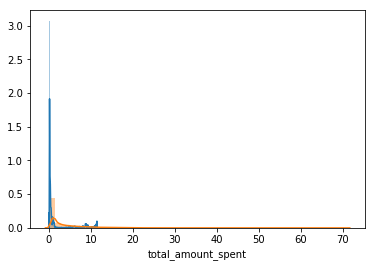

In [0]:
sns.distplot(act_oof_tas['infer_total_amount_spent']/act_oof_st['survival_time'])
sns.distplot(act_oof_tas['total_amount_spent'])

In [0]:
TYPE='activity'
FOLDS=5
SEED=42
select_model='ridge'

activity_model = model(act_train, train_label, act_test1, act_test2, TYPE, FOLDS, SEED)
activity_model.labeling()
activity_model.train_st(XGB_PARAMS_ST, 5000, select_model)
act_oof_st = activity_model.infer_oof(select_model)

activity_model.labeling_tas(train_payment)
activity_model.train_tas(XGB_PARAMS_TAS, 50000, select_model)
act_oof_tas = activity_model.infer_tas_oof(select_model)

In [0]:
TYPE='payment'

payment_model = model(pay_train, train_label, pay_test1, pay_test2, TYPE, FOLDS, SEED)
payment_model.labeling()
payment_model.train_st(PARAMS_ST, 5000, select_model)
pay_oof_st = payment_model.infer_oof(select_model)

payment_model.labeling_tas(train_payment)
payment_model.train_tas(PARAMS_TAS, 50000, select_model)
pay_oof_tas = payment_model.infer_tas_oof(select_model)

In [0]:
TYPE='trade'

trade_model = model(tra_train, train_label, tra_test1, tra_test2, TYPE, FOLDS, SEED)
trade_model.labeling()
trade_model.train_st(PARAMS_ST, 5000, select_model)
tra_oof_st = trade_model.infer_oof(select_model)

trade_model.labeling_tas(train_payment)
trade_model.train_tas(PARAMS_TAS, 50000, select_model)
tra_oof_tas = trade_model.infer_tas_oof(select_model)

In [0]:
TYPE='combat'

combat_model = model(com_train, train_label, com_test1, com_test2, TYPE, FOLDS, SEED)
combat_model.labeling()
combat_model.train_st(PARAMS_ST, 5000, select_model)
com_oof_st = combat_model.infer_oof(select_model)

combat_model.labeling_tas(train_payment)
combat_model.train_tas(PARAMS_TAS, 50000, select_model)
com_oof_tas = combat_model.infer_tas_oof(select_model)

In [0]:
TYPE='pledge'

pledge_model = model(ple_train, train_label, ple_test1, ple_test2, TYPE, FOLDS, SEED)
pledge_model.labeling()
pledge_model.train_st(PARAMS_ST, 5000, select_model)
ple_oof_st = pledge_model.infer_oof(select_model)

pledge_model.labeling_tas(train_payment)
pledge_model.train_tas(PARAMS_TAS, 5000, select_model)
ple_oof_tas = pledge_model.infer_tas_oof(select_model)

## main

In [0]:
fis = joblib.load("/content/drive/My Drive/bigcontest2019/scripts/hh's work/feature_importance/feature_importance.ckpt")
fis = fis['Feature'].tolist()
fis.extend(['acc_id', 'week'])

def feature_selection(data, fis):
    df = data.copy()
    
    for column in df.columns[[column[-3:]=='sum' for column in df.columns]][1:]:
        df['derive' + str(column)] = df[column]/df['playtimesum']
    else:
        df = df[fis]
        return df

TYPE='activity'
FOLDS=5
SEED=42
select_model='xgb'

main_model = model(feature_selection(train, fis), train_label, feature_selection(test1, fis), feature_selection(test2, fis), TYPE, FOLDS, SEED)
main_model.labeling()
main_model.train_st(XGB_PARAMS_ST, 5000, select_model)
oof_st = main_model.infer_oof(select_model)

main_model.labeling_tas(train_payment)
main_model.train_tas(XGB_PARAMS_TAS, 50000, select_model)
oof_tas = main_model.infer_tas_oof(select_model)

# joblib.dump(feature_imp.iloc[-50:], "/content/drive/My Drive/bigcontest2019/scripts/hh's work/feature_importance/feature_importance.ckpt")

NameError: ignored

In [0]:
act_pred_st1, act_pred_st2 = activity_model.infer_pred()
act_pred_tas1, act_pred_tas2 = activity_model.infer_tas_pred()

# pay_pred_st1, pay_pred_st2 = payment_model.infer_pred()
# pay_pred_tas1, pay_pred_tas2 = payment_model.infer_tas_pred()

# tra_pred_st1, tra_pred_st2 = trade_model.infer_pred()
# tra_pred_tas1, tra_pred_tas2 = trade_model.infer_tas_pred()

# com_pred_st1, com_pred_st2 = combat_model.infer_pred()
# com_pred_tas1, com_pred_tas2 = combat_model.infer_tas_pred()

# ple_pred_st1, ple_pred_st2 = pledge_model.infer_pred()
# ple_pred_tas1, ple_pred_tas2 = pledge_model.infer_tas_pred()

In [0]:
oop_st = pd.concat([act_oof_st, pay_oof_st, tra_oof_st, com_oof_st, ple_oof_st]).groupby('acc_id').median().reset_index()
# oop_st = pd.concat([act_oof_st, pay_oof_st, tra_oof_st, com_oof_st, ple_oof_st]).groupby('acc_id').agg(lambda x: x.value_counts().index[0]).reset_index()
oop_tas = pd.concat([act_oof_tas, pay_oof_tas, tra_oof_tas, com_oof_tas, ple_oof_tas]).groupby('acc_id').median().reset_index()

## Score

In [0]:
# metrics
from scripts.metrics.score_function import score_function

def oof_transform(st, tas):
    st_t = st.copy()
    tas_t = tas.copy()

    tas_t.loc[tas['infer_total_amount_spent']<0, 'infer_total_amount_spent'] = 0
    
    oof_df = pd.merge(st_t, tas_t, how='left', on='acc_id')[['acc_id', 'infer_survival_time', 'infer_total_amount_spent']]
    oof_df.columns = ['acc_id', 'survival_time', 'amount_spent']
    oof_df['amount_spent'] = oof_df['amount_spent']/oof_df['survival_time']
    return oof_df

def pred_transform(st, tas, acc_id):
    st_t = st.copy()
    tas_t = tas.copy()
    
    st_t['survival_time'] = st_t.drop(columns='acc_id').median(1)
    tas_t['amount_spent'] = tas_t.drop(columns='acc_id').max(1)
    
    pred_df = pd.merge(st_t, tas_t, how='left', on='acc_id')[['acc_id', 'survival_time', 'amount_spent']]
    pred_df['amount_spent'] = pred_df['amount_spent']/pred_df['survival_time']
    
    pred_df = pred_df[pred_df['acc_id'].isin(acc_id)]
    return pred_df

# 예측, 실제
score_function(oof_transform(act_oof_st, act_oof_tas),
               true_train_label)

25336.930903499248


25336.930903499248

**< activity >**
- gb  : 28578.874791769602
- hgb  : 27700.83815941454

- hgb  / max 8 &4 / n_est =1000 : 30244.73070329627
- hgb  / both max 8 / n_est =1000 : 30583.270177103517 (fix)

- xgb / learning  0.1 : 29600.5030351777
- xgb / learning 0.01 both :14345.147588257376

- ridge : 25849.32819969437

- extra : 25336.930903499248


**< combat >**
- hgb / both max 8 / n_est =1000 : 28884.104269502062

**< pledge >**
- hgb : 

**< trade >**

- hgb : 

In [0]:
os.getcwd()

'/content/drive/My Drive/bigcontest2019'

In [0]:
test1_predict=pred_transform(act_pred_st1,act_pred_tas1,test1['acc_id'])
test2_predict=pred_transform(act_pred_st2,act_pred_tas2,test2['acc_id'])
test1_predict.to_csv('test1_predict.csv',encoding='utf-8')
test2_predict.to_csv('test2_predict.csv',encoding='utf-8')

# submission

In [0]:
pred1_st = pd.concat([act_pred_st1, pay_pred_st1, tra_pred_st1, com_pred_st1, ple_pred_st1]).groupby('acc_id').median().reset_index()
pred1_tas = pd.concat([act_pred_tas1, pay_pred_tas1, tra_pred_tas1, com_pred_tas1, ple_pred_tas1]).groupby('acc_id').median().reset_index()

pred2_st = pd.concat([act_pred_st2, pay_pred_st2, tra_pred_st2, com_pred_st2, ple_pred_st2]).groupby('acc_id').median().reset_index()
pred2_tas = pd.concat([act_pred_tas2, pay_pred_tas2, tra_pred_tas2, com_pred_tas2, ple_pred_tas2]).groupby('acc_id').median().reset_index()

In [0]:
pred_transform(pred1_st, pred1_tas, test1_activity['acc_id'].unique()).to_csv('/content/test1_predict.csv', index=False)
pred_transform(pred2_st, pred2_tas, test2_activity['acc_id'].unique()).to_csv('/content/test2_predict.csv', index=False)

In [0]:
pred_transform(act_pred_st1, act_pred_tas1, test1_activity['acc_id'].unique()).to_csv('/content/test1_predict.csv', index=False)
pred_transform(act_pred_st2, act_pred_tas2, test2_activity['acc_id'].unique()).to_csv('/content/test2_predict.csv', index=False)

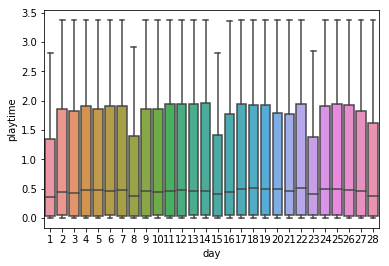

In [0]:
sns.boxplot(data = train_activity,x = 'day',y='playtime')

# sns.boxplot(data = test1_activity,y='playtime',hue='day')
# sns.boxplot(data = test2_activity,y='playtime',hue='day')

# sns.boxplot(test1_activity['day'],test1_activity['playtime'])
# sns.distplot(test2_activity['playtime'])


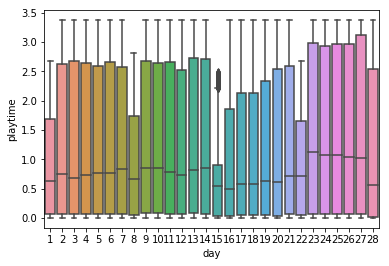

In [0]:
sns.boxplot(data = test1_activity,x = 'day',y='playtime')


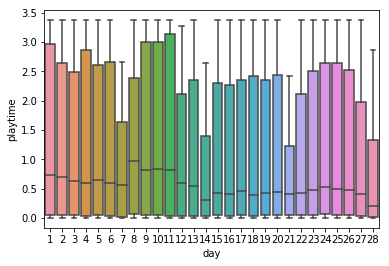

In [0]:
sns.boxplot(data = test2_activity,x = 'day',y='playtime')


In [0]:
tmp =train_activity.groupby(['acc_id','day']).agg({'playtime':'sum'}).reset_index().groupby(['acc_id']).agg({'day':'min','playtime':'sum'}).reset_index()

In [0]:
df = pd.merge(tmp,train_label,how='left',on='acc_id')
df['week'] = (df['day']//7)+1

In [0]:
df['week'].value_counts()

1    34845
2     2066
3     1077
5     1045
4      967
Name: week, dtype: int64

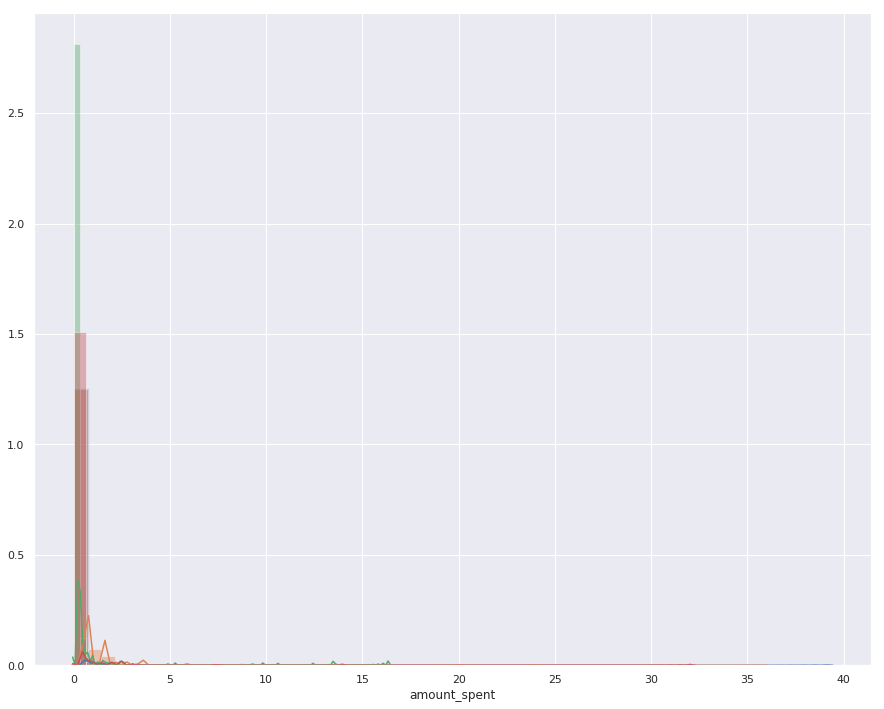

In [0]:
# sns.lineplot(x = 'day',y ='amount_spent',hue='week',data = df)
# sns.distplot('amount_spent',hue='week',data = df)

sns.distplot(df.loc[df['week']==1,'amount_spent'])
sns.distplot(df.loc[df['week']==2,'amount_spent'])
sns.distplot(df.loc[df['week']==3,'amount_spent'])
sns.distplot(df.loc[df['week']==4,'amount_spent'])


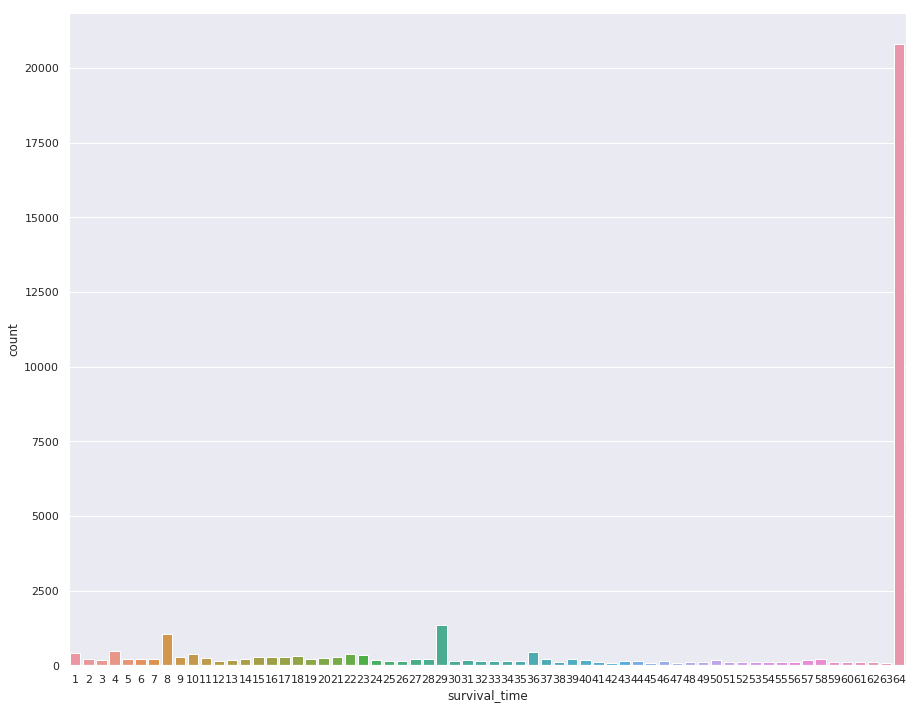

In [0]:
sns.set(rc={'figure.figsize':(15,12)})

sns.countplot('survival_time',data = df[df['week']==1])

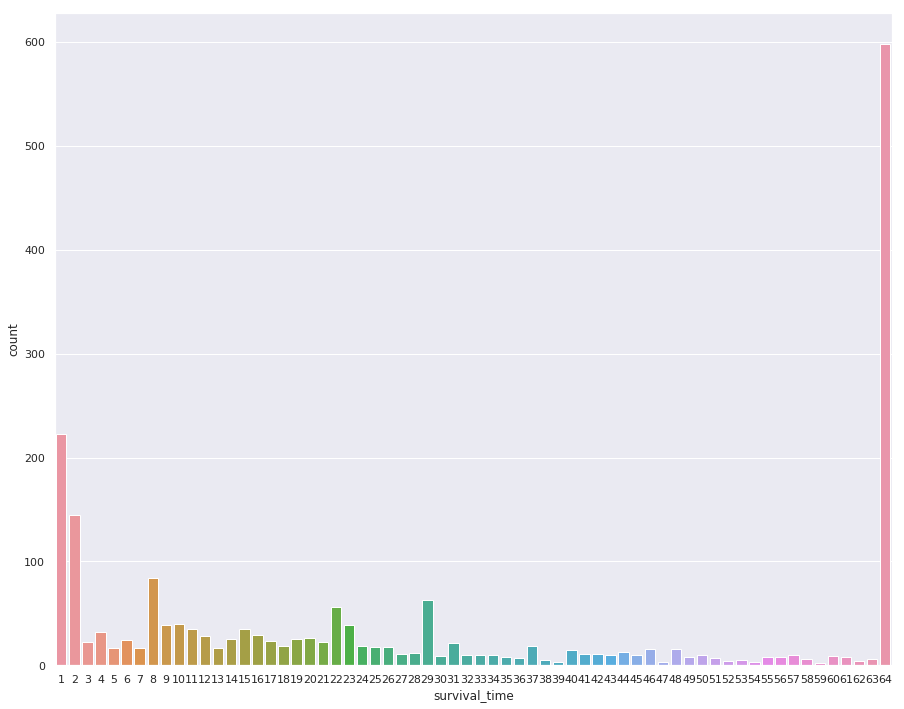

In [0]:
sns.countplot('survival_time',data = df[df['week']==2])

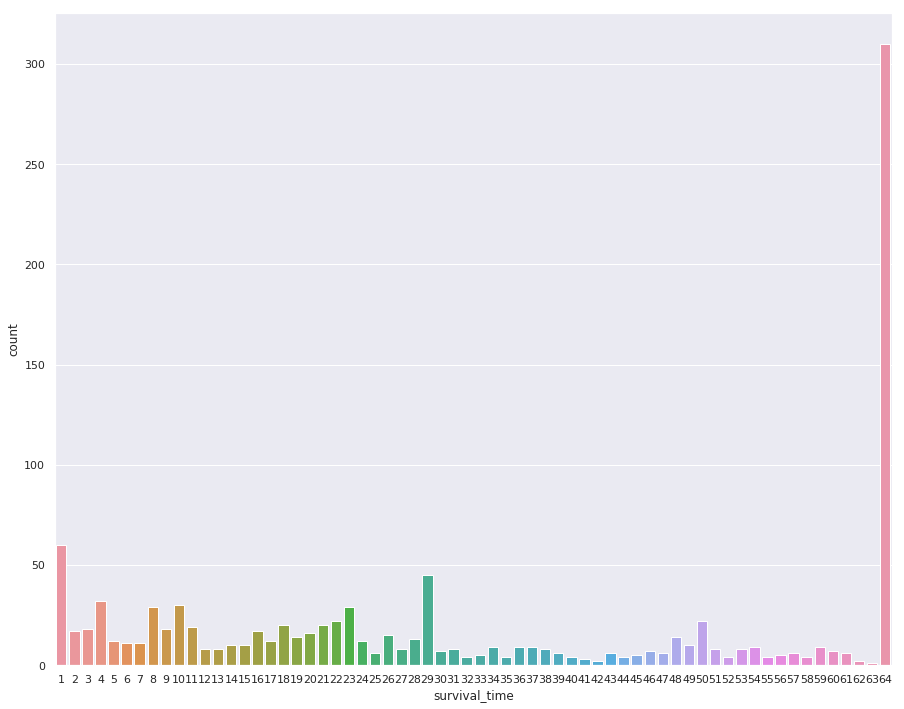

In [0]:
sns.countplot('survival_time',data = df[df['week']==3])

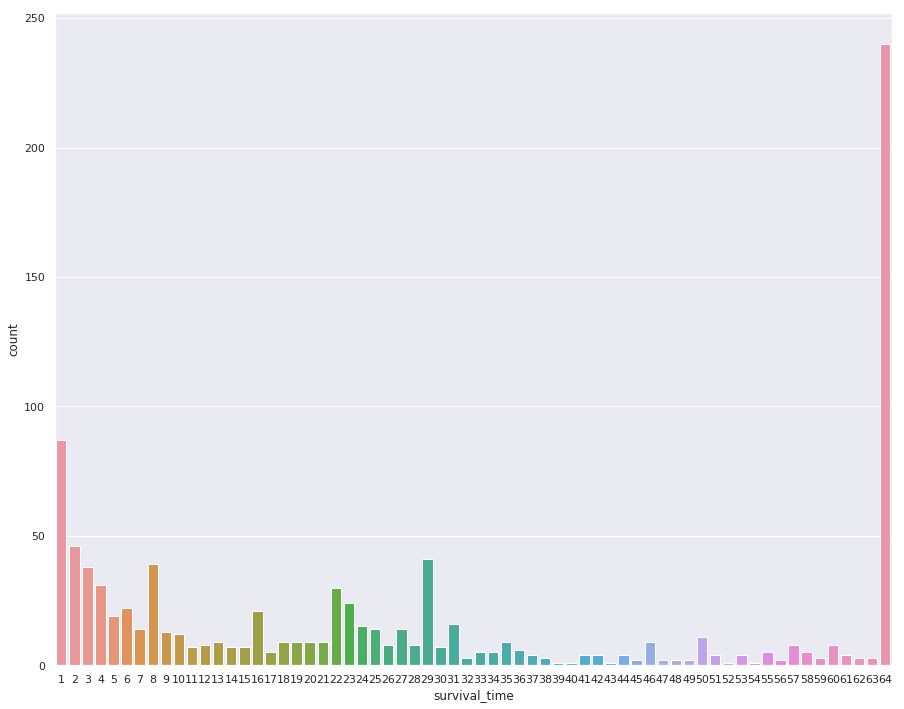

In [0]:
sns.countplot('survival_time',data = df[df['week']==4])

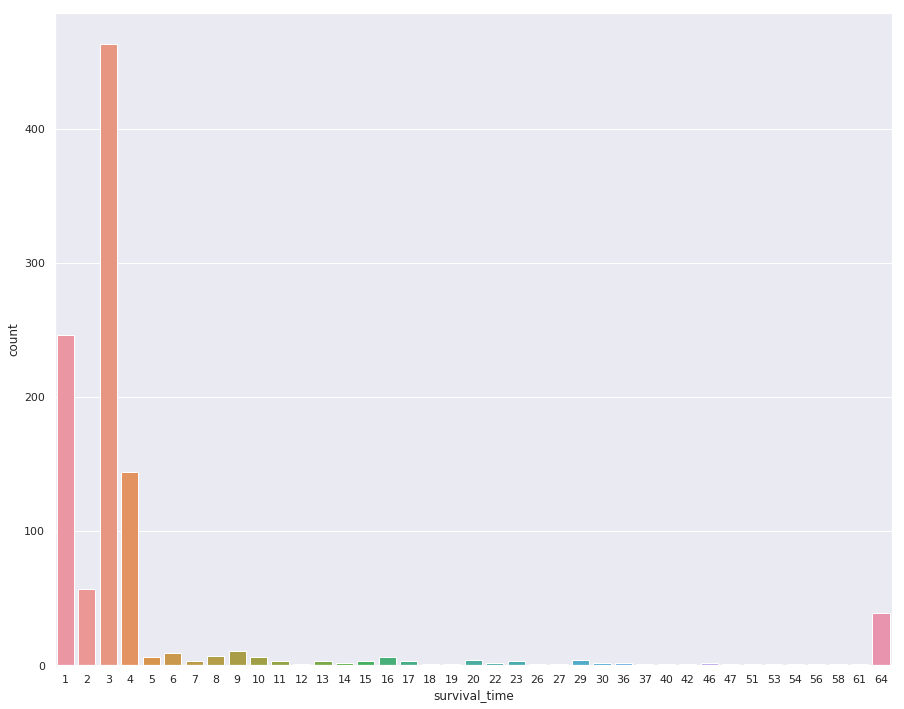

In [0]:
sns.countplot('survival_time',data = df[df['week']==5]) # 28일에 시작한 친구

In [0]:
(train_payment[train_payment['amount_spent']>0]['amount_spent']).min(),
(test1_payment[test1_payment['amount_spent']>0]['amount_spent']).min(),
(test2_payment[test2_payment['amount_spent']>0]['amount_spent']).min(),


(0.01173470155204053,)

(0.01173470155204053,)

(0.01173470155204053,)